# Context

Recent studies have shown that breast cancer continues to be the leading cause of death among women over the world. If detected at an early stage, it can be cured in 9 out of 10 cases.

Automated detection and segmentation of cells from images are the crucial and fundamental steps for the measurement of cellular morphology that is crucial for brest cancer diagnosis and prognosis.


In this notebook, you will learn how to train a segmentation as UNet with **monai** - a framwork based Pytorch Stadard for healthcare imaging.

## Monai

MONAI is a pytorch based open source AI framework launched by NVIDIA and King’s College London.
It is integrated with training and modelling workflows in a native PyTorch Standard. t several places.


Install monai

In [1]:
!pip install -qU "monai[all]==1.0.0"

Check the installation by running the following cell

In [2]:
import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
import monai
from PIL import Image
monai.config.print_config()

MONAI version: 1.0.0
Numpy version: 1.26.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 170093375ce29267e45681fcec09dfa856e1d7e7
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 5.3.2
scikit-image version: 0.25.0
Pillow version: 11.1.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.14.1+cu117
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.21.3
mlflow version: 2.19.0
pynrrd version: 1.1.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#  Dataset

To train a model, we need to prepare some ingredients:

1. Dataset
2. Model
3. Loss function
4. Optimizer

# I. Create Dataset

There are two ways to create your dataset:
- with pytorch Dataset
- with monai.data.Dataset.

In this exercise, we will create our dataset using torch.utils.data.Dataset.

## 1. List all files in folder

Download the dataset from https://zenodo.org/record/1175282#.YMn_Qy-FDox

Notice that there are two kind of folder : original cell picture folder and mask folders. Using your file explorer or some code, display one image and the corresponding image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!wget https://zenodo.org/record/1175282#.YMn_Qy-FDox

--2025-01-09 00:10:57--  https://zenodo.org/record/1175282
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1175282 [following]
--2025-01-09 00:10:58--  https://zenodo.org/records/1175282
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 68047 (66K) [text/html]
Saving to: ‘1175282.2’

1175282.2           100%[===================>]  66.45K   202KB/s    in 0.3s    

2025-01-09 00:10:59 (202 KB/s) - ‘1175282.2’ saved [68047/68047]



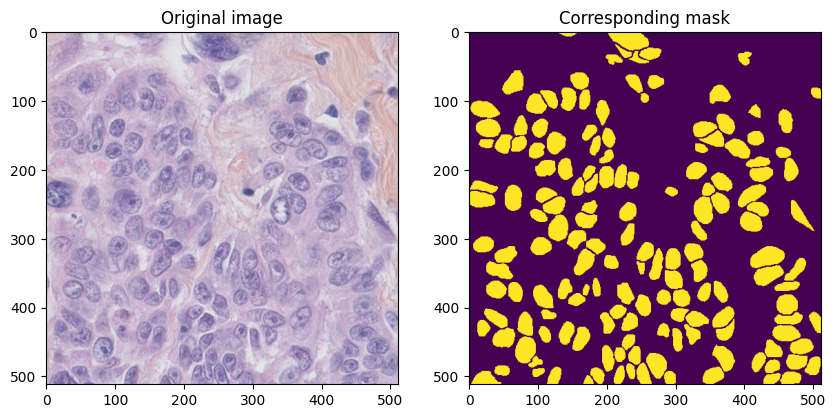

In [5]:
dataset_path = '/content/drive/MyDrive/TNBC_NucleiSegmentation'

first_patient = '01'
imgdrive = os.path.join(dataset_path, 'Slide_' + first_patient)
maskdrive = os.path.join(dataset_path, 'GT_' + first_patient)
img_files = [f for f in os.listdir(imgdrive) if os.path.isfile(os.path.join(imgdrive, f))]
img_file = img_files[3]
img_path = os.path.join(imgdrive, img_file)
mask_file = img_file
mask_path = os.path.join(maskdrive, mask_file)
img = Image.open(img_path)
mask = Image.open(mask_path)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Corresponding mask')

plt.show()

## 2. Define a transform
When you load your data, you need to define some transformation. For example, we want to convert image to the format [num_channels, spatial_dim_1, spatial_dim_2] because monai/pytorch use this format. We'll also need to convert the images to PyTorch tensors with transforms.ToTensor()

The following code lets you load image and the labels and define several steps to transform the data.


In [6]:
import torch

from monai.transforms import Compose, LoadImage, AsChannelFirst, ToTensor, AddChannel, NormalizeIntensity
from monai.transforms import ScaleIntensity

from monai.data import PILReader

image_trans = Compose(
    [
        LoadImage(image_only=True, reader = PILReader(converter=lambda image: image.convert("RGB"))),
        AsChannelFirst(),
        NormalizeIntensity(),
        ToTensor(),
    ])


label_trans = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        ToTensor(),
    ])

<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.



## 3. Create dataset

The following class CellDataset allows us to create our dataset from "image_files" and "label_files" where:
- "image_files" is a list of image names
- "label_files" is the list of segmentation names respectively.

"im_trans" and "label_trans" are respectively the transforms for the images and their labels.




In [7]:
import torch

class CellDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, label_files, im_trans, label_trans):
        self.image_files = image_files
        self.label_files = label_files
        self.im_trans = im_trans
        self.label_trans = label_trans

    def __len__(self):
        return(len(self.image_files))

    def __getitem__(self, index):
        return self.im_trans(self.image_files[index]), self.label_trans(self.label_files[index])



By using this class, create your training dataset et your test dataset. Remember to check if your dataset is loaded correctly.

In [8]:
img_files = []
label_files = []
for i in range(1, 12):
  dir_sl = f"Slide_{i:02d}"
  dir_gt = f"GT_{i:02d}"
  path_sl = os.path.join(dataset_path, dir_sl)
  path_gt = os.path.join(dataset_path, dir_gt)
  sl_img = glob.glob(os.path.join(path_sl, "*.png"))
  for i in sl_img:
    f = os.path.basename(i)
    m = os.path.join(path_gt, f)
    if os.path.isfile(m):
      img_files.append(i)
      label_files.append(m)
print(len(img_files))
print(len(label_files))

ind = int(0.8 * len(img_files))

train_img = img_files[:ind]
train_label = label_files[:ind]
test_img = img_files[ind:]
test_label = label_files[ind:]



train_dataset = CellDataset(image_files=train_img, label_files=train_label, im_trans=image_trans, label_trans=label_trans) # to change
test_dataset = CellDataset(image_files=test_img, label_files=test_label, im_trans=image_trans, label_trans=label_trans) #todo

50
50


## 4. DataLoader

With the your dataset loaded, you have to pass it to a DataLoader. The torch.utils.data.DataLoader takes a dataset and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.


The following code let you create a data loader for the train dataset, do the same to create a test_loader on the test_dataset. Name it **test_load**


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=2)

## 5. Now, time to check your dataloader.

Execute the code following to check if your dataloader works correctly

In [10]:
import monai
im, seg = monai.utils.misc.first(train_loader)
im.shape

(2, 3, 512, 512)

# II. Build your segmentation model with monai

Monai already has a UNet model architecture : https://docs.monai.io/en/stable/networks.html#unet

By using the monai.networks.nets module, build a UNet model for segmentation task in 2D. You'll have to choose the following parameters for the model:

1. dimensions (number of spatial dimensions)
2. in_channels (number of input channel)
3. out_channels (number of output channel)
4. channels
5. strides


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(2, 3, 1, (16, 32, 64, 128, 256), (2, 2, 2, 2), num_res_units=2).to(device)

# III. Define your loss function and optimizer

For a segmentation prob, we usually use DiceLoss.
Using monai.losses.DiceLoss, define your loss function and store it in the variable named **loss_function**. The option sigmoid = True should be used.




In [12]:
from monai.losses import DiceLoss
loss_function = DiceLoss(sigmoid=True)

With torch.optim, define an optimizer for your model. Use the Adam optimiser



In [13]:
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# IV. Trainning the model

This time, we have all ingredients to train a segmentation model: a model, an optimizer, train_loader and a loss function.  

Monai use a standard PyTorch program style for training a deep learning model.


The general process with Monai/Pytorch just for one learning step  as follows:

1. Load input and label of each batch.

2. Zero accumulated gradients with optimizer.zero_grad()

3. Compute the output from the model

4. Calculate the loss

5. Perform backprop with loss.backward()

6. Update the optimizer with optimizer.step()


Complete the following code so that it do the training


In [14]:
epoch_loss_values = list()
for epoch in range(5):

    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions = model(inputs)

        # compute the loss using the loss function, the predictions and labels
        loss = loss_function(predictions, labels)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss.backward()

        # call the step method of the optimizer
        optimizer.step()

        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")


    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


1/20, train_loss: 0.7506
2/20, train_loss: 0.9209
3/20, train_loss: 0.6782
4/20, train_loss: 0.7185
5/20, train_loss: 0.7264
6/20, train_loss: 0.5808
7/20, train_loss: 0.7631
8/20, train_loss: 0.6464
9/20, train_loss: 0.6938
10/20, train_loss: 0.7077
11/20, train_loss: 0.6846
12/20, train_loss: 0.6435
13/20, train_loss: 0.9141
14/20, train_loss: 0.6610
15/20, train_loss: 0.7853
16/20, train_loss: 0.6480
17/20, train_loss: 0.5805
18/20, train_loss: 0.8096
19/20, train_loss: 0.7460
20/20, train_loss: 0.8102
epoch 1 average loss: 0.7235
1/20, train_loss: 0.7233
2/20, train_loss: 0.6974
3/20, train_loss: 0.7292
4/20, train_loss: 0.5692
5/20, train_loss: 0.5441
6/20, train_loss: 0.8539
7/20, train_loss: 0.6845
8/20, train_loss: 0.8480
9/20, train_loss: 0.6876
10/20, train_loss: 0.8816
11/20, train_loss: 0.7159
12/20, train_loss: 0.5274
13/20, train_loss: 0.7268
14/20, train_loss: 0.7453
15/20, train_loss: 0.6900
16/20, train_loss: 0.6089
17/20, train_loss: 0.6932
18/20, train_loss: 0.6355
1

Display the prediction of your model on several image

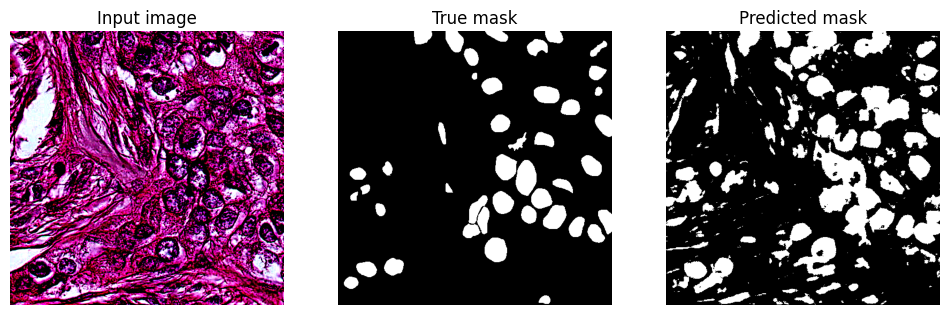

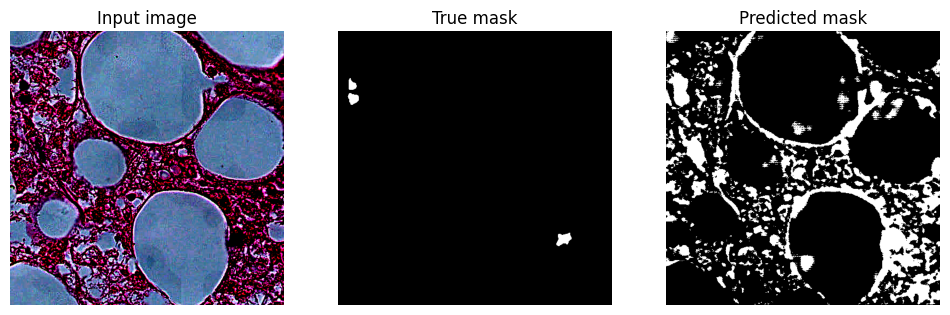

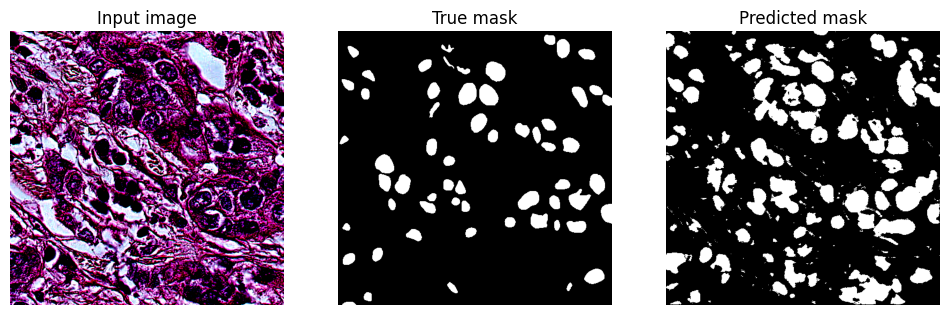

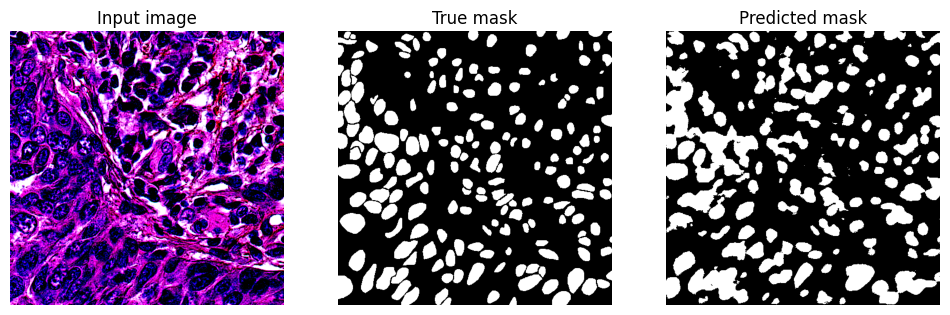

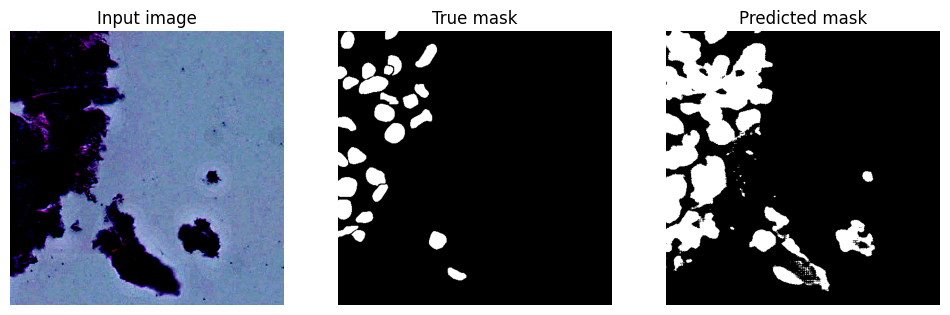

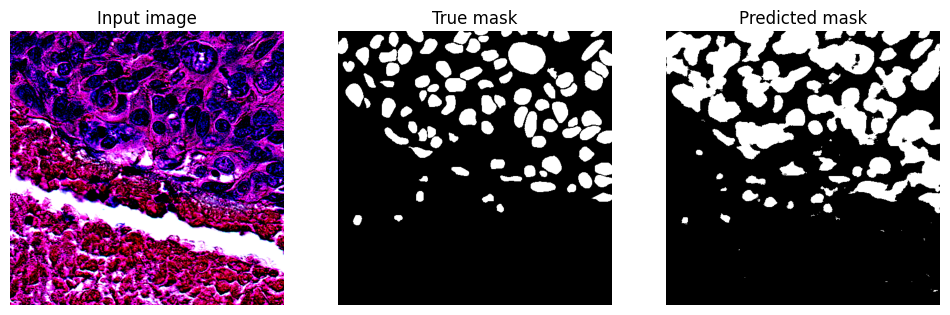

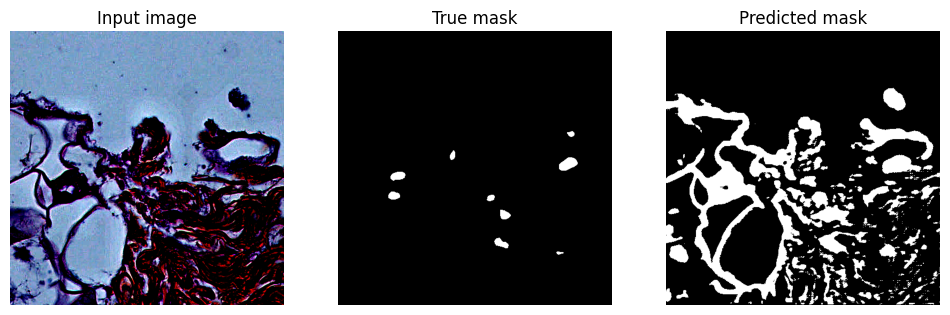

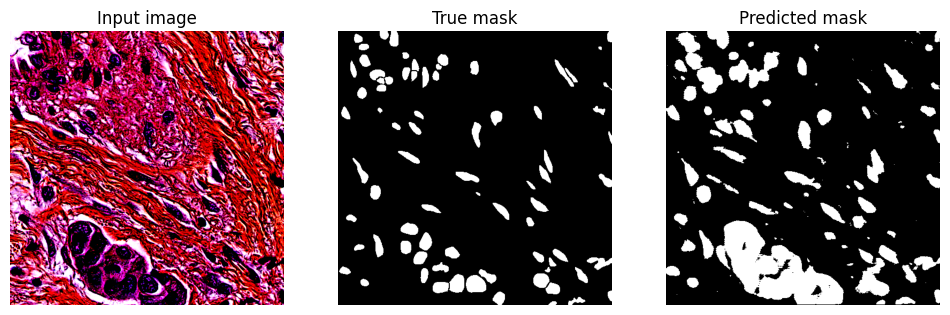

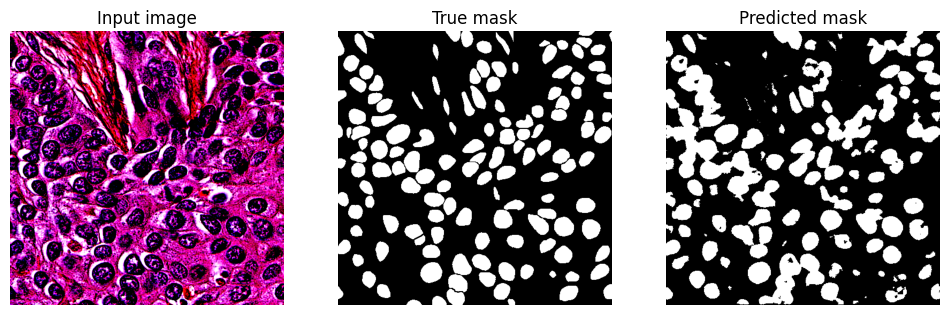

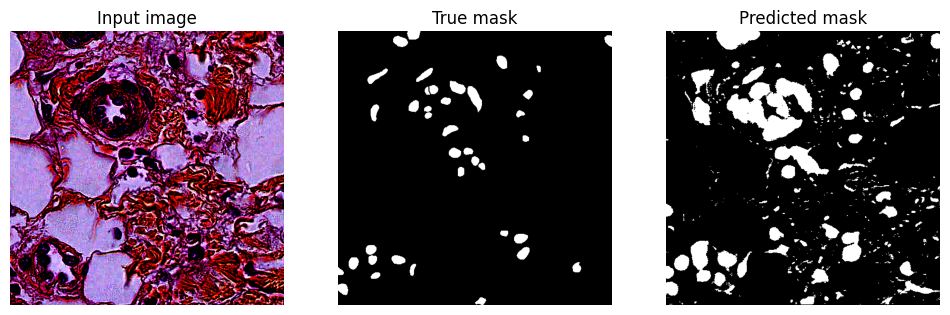

In [15]:
model.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        inputs = inputs.cpu()
        labels = labels.cpu()
        preds = preds.cpu()

        for j in range(inputs.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(inputs[j].permute(1, 2, 0))
            plt.title('Input image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(labels[j].squeeze(), cmap='gray')
            plt.title('True mask')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(preds[j].squeeze(), cmap='gray')
            plt.title('Predicted mask')
            plt.axis('off')
            plt.show()

Train another architecture (either another Unet architecture or find another segmentation model in the available models of Monai). Compare the results with the first model

In [16]:
model2 = monai.networks.nets.AttentionUnet(spatial_dims=2, in_channels=3, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2)).to(device)
loss_function2 = DiceLoss(sigmoid=True)
optimizer2 = torch.optim.Adam(model2.parameters(), 1e-3)

epoch_loss_values2 = list()
for epoch in range(5):

    model2.train()
    epoch_loss2 = 0
    step2 = 0
    for batch_data in train_loader:
        step2 += 1
        inputs2, labels2 = batch_data[0].to(device), batch_data[1].to(device)
        optimizer2.zero_grad()

        #compute the model predictions using the model variable and inputs
        predictions2 = model2(inputs2)

        # compute the loss using the loss function, the predictions and labels
        loss2 = loss_function(predictions2, labels2)

        # use the backward method of the loss variable to  compute the gradient of the loss used to find the minimum of the loss function
        loss2.backward()

        # call the step method of the optimizer
        optimizer2.step()

        epoch_loss2 += loss2.item()
        epoch_len2 = len(train_dataset) // train_loader.batch_size
        print(f"{step2}/{epoch_len2}, train_loss: {loss2.item():.4f}")


    epoch_loss2 /= step2
    epoch_loss_values2.append(epoch_loss2)
    print(f"epoch {epoch + 1} average loss: {epoch_loss2:.4f}")


1/20, train_loss: 0.7584
2/20, train_loss: 0.7753
3/20, train_loss: 0.7140
4/20, train_loss: 0.8760
5/20, train_loss: 0.8122
6/20, train_loss: 0.7243
7/20, train_loss: 0.7141
8/20, train_loss: 0.4914
9/20, train_loss: 0.7558
10/20, train_loss: 0.6933
11/20, train_loss: 0.7495
12/20, train_loss: 0.8595
13/20, train_loss: 0.6211
14/20, train_loss: 0.6231
15/20, train_loss: 0.6075
16/20, train_loss: 0.8096
17/20, train_loss: 0.5523
18/20, train_loss: 0.7003
19/20, train_loss: 0.5674
20/20, train_loss: 0.7824
epoch 1 average loss: 0.7094
1/20, train_loss: 0.7847
2/20, train_loss: 0.5525
3/20, train_loss: 0.6429
4/20, train_loss: 0.6694
5/20, train_loss: 0.6264
6/20, train_loss: 0.7938
7/20, train_loss: 0.6176
8/20, train_loss: 0.4969
9/20, train_loss: 0.7024
10/20, train_loss: 0.6668
11/20, train_loss: 0.7305
12/20, train_loss: 0.5515
13/20, train_loss: 0.6316
14/20, train_loss: 0.5258
15/20, train_loss: 0.8267
16/20, train_loss: 0.9111
17/20, train_loss: 0.7181
18/20, train_loss: 0.6310
1

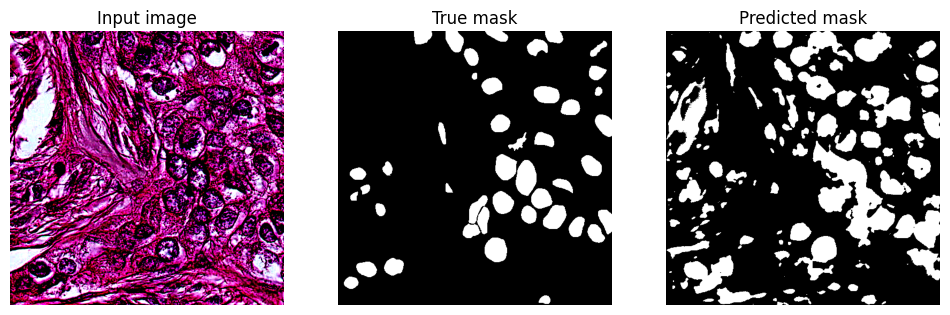

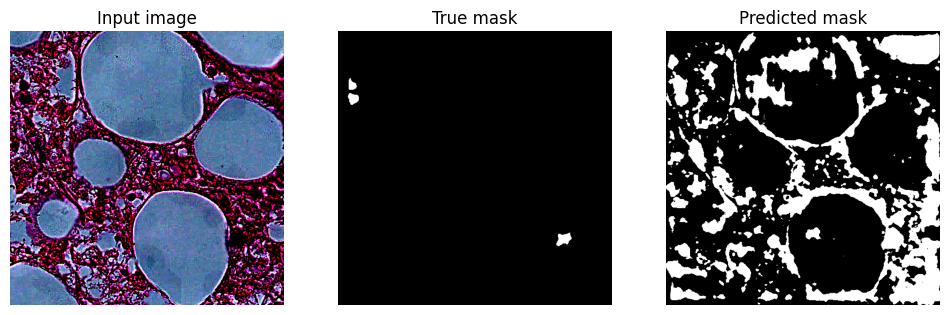

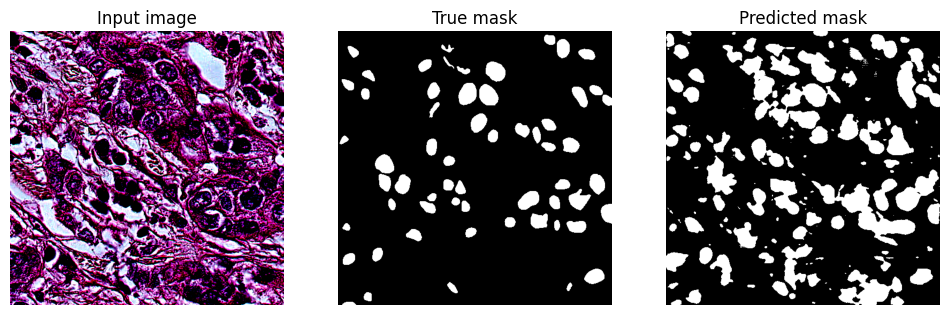

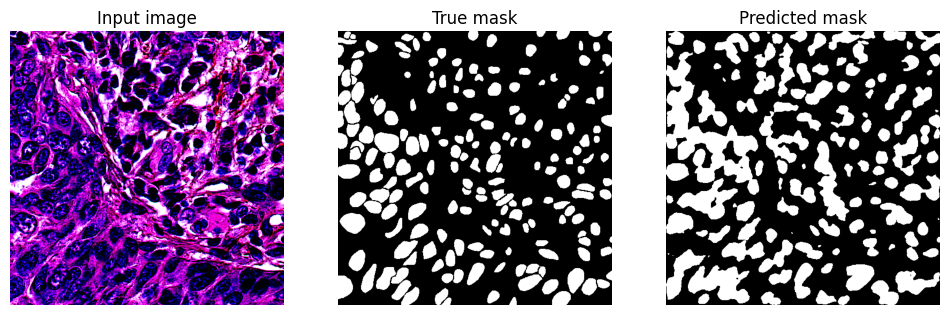

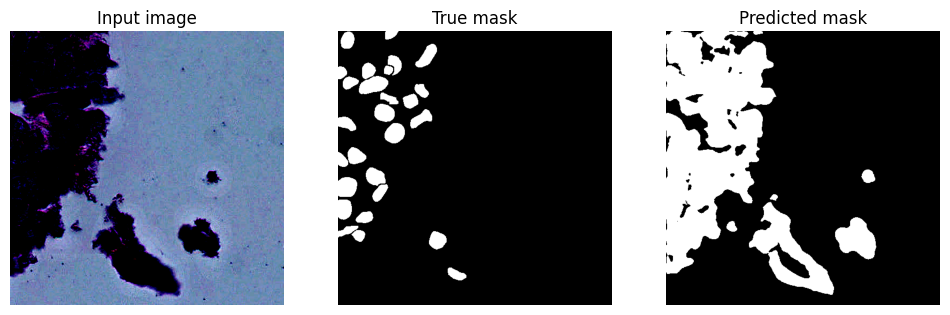

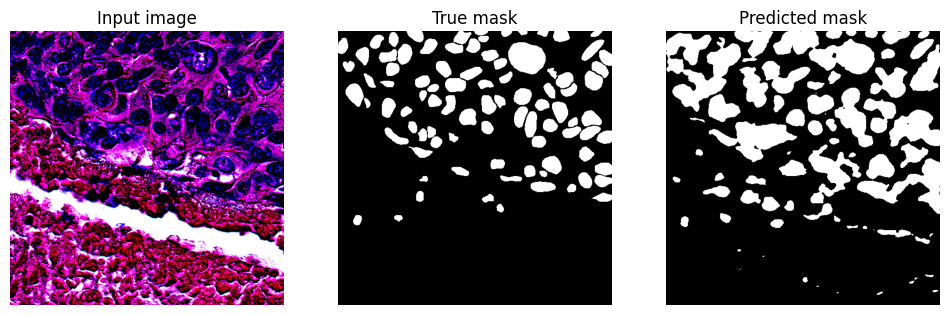

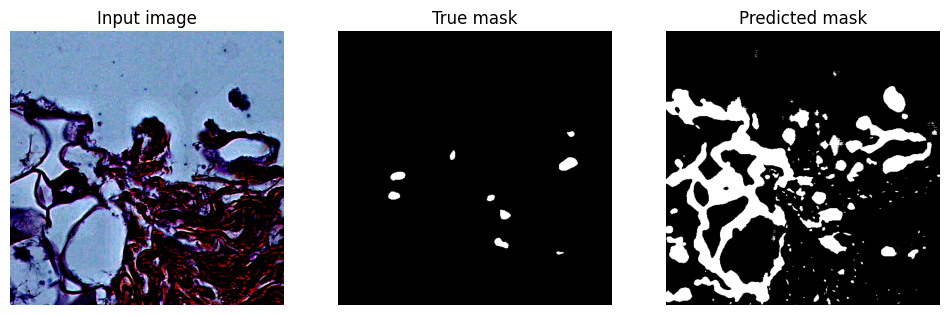

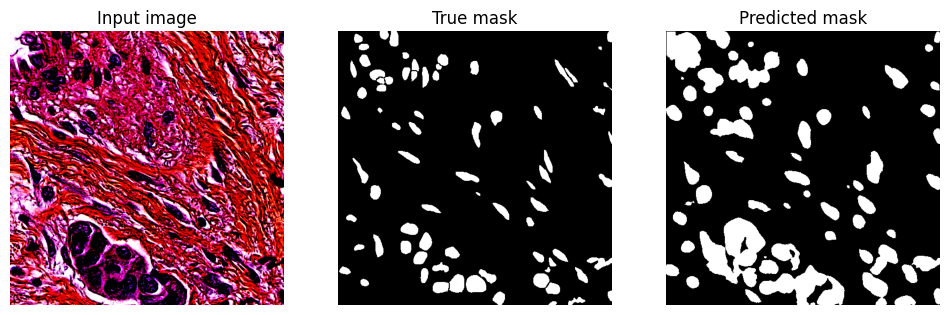

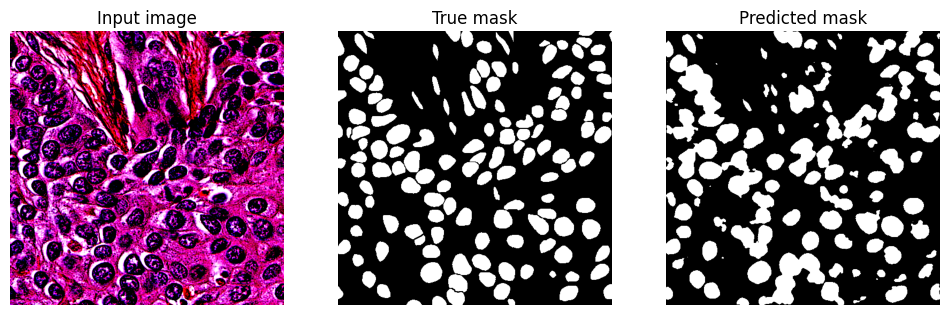

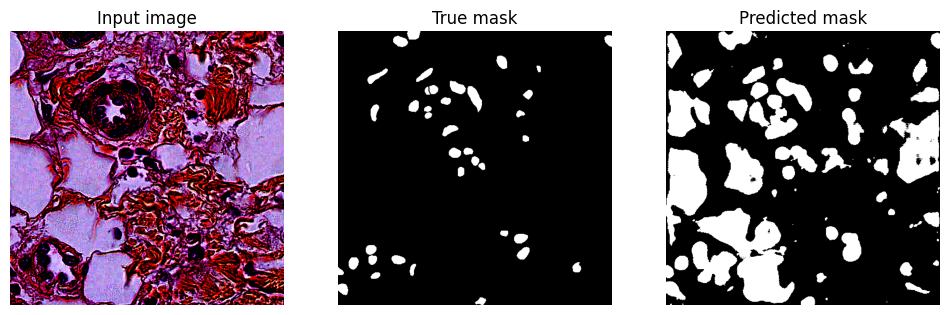

In [17]:
model2.eval()
with torch.no_grad():
    for i, batch_data in enumerate(test_loader):
        inputs2, labels2 = batch_data[0].to(device), batch_data[1].to(device)
        outputs2 = model2(inputs2)
        preds2 = torch.sigmoid(outputs2) > 0.5
        inputs2 = inputs2.cpu()
        labels2 = labels2.cpu()
        preds2 = preds2.cpu()

        for j in range(inputs2.shape[0]):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(inputs2[j].permute(1, 2, 0))
            plt.title('Input image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(labels2[j].squeeze(), cmap='gray')
            plt.title('True mask')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(preds2[j].squeeze(), cmap='gray')
            plt.title('Predicted mask')
            plt.axis('off')
            plt.show()